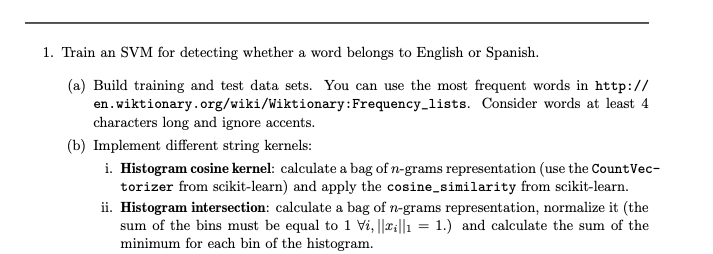

In [1]:
import nltk
import re
import random
from nltk.tokenize import word_tokenize
import pyphen
import numpy as np
# Cargar el texto en español desde el archivo
with open('./lista_palabras/espanol.txt', 'r', encoding='utf-8') as file_espanol:
    texto_espanol = file_espanol.read()

# Cargar el texto en inglés desde el archivo
with open('lista_palabras/ingles.txt', 'r', encoding='utf-8') as file_ingles:
    texto_ingles = file_ingles.read()



# Dividir el texto en palabras (español)
palabras_espanol = word_tokenize(texto_espanol)
random.shuffle(palabras_espanol)
# Dividir el texto en palabras (inglés)
palabras_ingles = word_tokenize(texto_ingles.lower())
random.shuffle(palabras_ingles)

def limpiar_palabra(palabra):
    #quitar dígitos
    palabra_limpia = re.sub(r'\d+','',palabra)
    #quitar símbolos raros
    palabra_limpia = re.sub(r'[\\]', ' ', palabra_limpia)
    #poner eñes (en los datos las eñes salen como espacios)
    palabra_limpia = re.sub(r' ', 'ñ', palabra_limpia)
    return palabra_limpia
def silabizarES(palabra):
    # Cargar el diccionario de sílabas para el idioma español
    diccionario_silabas = pyphen.Pyphen(lang='es')

    # Dividir la palabra en sílabas utilizando el diccionario
    sílabas = diccionario_silabas.inserted(palabra)

    # Reemplazar los guiones por espacios para separar las sílabas
    sílabas_separadas = sílabas.replace('-', ' ')

    return sílabas_separadas
def silabizarEN(palabra):
    # Cargar el diccionario de sílabas para el idioma español
    diccionario_silabas = pyphen.Pyphen(lang='en')

    # Dividir la palabra en sílabas utilizando el diccionario
    sílabas = diccionario_silabas.inserted(palabra)

    # Reemplazar los guiones por espacios para separar las sílabas
    sílabas_separadas = sílabas.replace('-', ' ')

    return sílabas_separadas

palabras_ingles = [limpiar_palabra(palabra) for palabra in palabras_ingles]
palabras_espanol = [limpiar_palabra(palabra) for palabra in palabras_espanol]
#considerar palabras largas
palabras_espanol = [palabra for palabra in palabras_espanol if len(palabra) > 3]
palabras_ingles = [palabra for palabra in palabras_ingles if len(palabra) > 3]
#silabizar palabras. Esto para que cada sílaba sea considerada y poder formar n_gramas de sílabas
palabras_espanol = [silabizarES(palabra) for palabra in palabras_espanol]
palabras_ingles = [silabizarEN(palabra) for palabra in palabras_ingles]

#que los conjuntos tengan la misma cantidad de palabras
palabras_espanol = palabras_espanol[0:5000]
palabras_ingles = palabras_ingles[0:5000]

# Crear una lista de etiquetas para las oraciones en español
etiquetas_espanol = ['español'] * len(palabras_espanol)

# Crear una lista de etiquetas para las oraciones en portugués
etiquetas_ingles = ['inglés'] * len(palabras_ingles)

# Combinar palabras y etiquetas en una lista de datos
datos_espanol = list(zip(palabras_espanol, etiquetas_espanol))
datos_ingles = list(zip(palabras_ingles, etiquetas_ingles))

# Combinar todos los datos en un solo conjunto de datos
datos = datos_espanol + datos_ingles
random.shuffle(datos)
#visualizar algunos datos
datos[0:10]


[('re lay', 'inglés'),
 ('fil ing', 'inglés'),
 ('di vi nar', 'español'),
 ('ben nett', 'inglés'),
 ('de ta llar', 'español'),
 ('re sort', 'inglés'),
 ('pack et', 'inglés'),
 ('corn wall', 'inglés'),
 ('vi treo', 'español'),
 ('zon ing', 'inglés')]

# Kernel similitud coseno #

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

palabras = [dato[0] for dato in datos]
etiquetas = [dato[1] for dato in datos]

# Crear vectores de características utilizando CountVectorizer
# ngram_range: cuáles n-gramas considerar
vectorizer = CountVectorizer(ngram_range =(1,3))
X = vectorizer.fit_transform(palabras)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, etiquetas, test_size=0.2, random_state=42)

# Calcular la similitud coseno entre los vectores de características
X_train_cosine = cosine_similarity(X_train)
X_test_cosine = cosine_similarity(X_test, X_train)

# Entrenar el modelo SVM con kernel de similitud coseno
svm_model_cosine = SVC(kernel='precomputed')
svm_model_cosine.fit(X_train_cosine, y_train)

# Predecir con el conjunto de prueba usando el modelo SVM
y_pred_cosine = svm_model_cosine.predict(X_test_cosine)

# Calcular la precisión del modelo
precision = accuracy_score(y_test, y_pred_cosine)
print("Precisión del modelo SVM con similitud coseno y vectorización con n-gramas por sílabas", precision)

Precisión del modelo SVM con similitud coseno y vectorización con n-gramas por sílabas 0.9395


# Kernel intersección de histogramas #

In [4]:
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.preprocessing import normalize
import numpy as np

# calcular el kernel entre dos histogramas (intersección de histogramas)
def inter_hist(hist1, hist2):
    
    # Calcular el mínimo valor entre los dos histogramas en cada bin
    min_values = hist1.minimum(hist2)
    # Calcular la suma de las áreas bajo la curva mínima (intersección)
    intersection = np.sum(min_values)
    return intersection
    
X_cut = X[0:1000]
etiquetas_cut = etiquetas[0:1000]
# Dividir los datos en entrenamiento y prueba (usamos menos datos porque se demora mucho en correr)
X_train, X_test, y_train, y_test = train_test_split(X_cut, etiquetas_cut, test_size=0.2, random_state=42)
X_train_normalized = normalize(X_train,axis=1,norm='l1')
X_test_normalized = normalize(X_test,axis=1,norm='l1')



In [5]:
X_train_hist = pairwise_kernels(X_train_normalized, metric=inter_hist, n_jobs=-1)


In [6]:
X_test_hist = pairwise_kernels(X_test_normalized,X_train_normalized, metric=inter_hist, n_jobs=-1)

In [7]:
svm_model_hist = SVC(kernel='precomputed')
svm_model_hist.fit(X_train_hist, y_train)


SVC(kernel='precomputed')

In [8]:
y_pred_hist = svm_model_hist.predict(X_test_hist)
precision = accuracy_score(y_test, y_pred_hist)
print("Precisión del modelo SVM con intersección de histogramas y vectorización con n-gramas por sílabas", precision)

Precisión del modelo SVM con intersección de histogramas y vectorización con n-gramas por sílabas 0.93


# $\chi^2$ kernel

In [7]:
from sklearn.metrics.pairwise import chi2_kernel
X_cut = X[0:2000]
etiquetas_cut = etiquetas[0:2000]
# Dividir los datos en entrenamiento y prueba (usamos menos datos porque se demora mucho en correr)
X_train, X_test, y_train, y_test = train_test_split(X_cut, etiquetas_cut, test_size=0.2, random_state=42)
X_train_chi2 = chi2_kernel(X_train.toarray())
X_test_chi2 = chi2_kernel(X_test.toarray(), X_train.toarray())

svm_model_chi2 = SVC(kernel='precomputed')
svm_model_chi2.fit(X_train_chi2, y_train)

y_pred_chi2 = svm_model_chi2.predict(X_test_chi2)

# Calcular la precisión del modelo
precision = accuracy_score(y_test, y_pred_chi2)
print("Precisión del modelo SVM con chi2 y vectorización con n-gramas por sílabas", precision)

Precisión del modelo SVM con chi2 y vectorización con n-gramas por sílabas 0.755


# ssk python kernel

In [12]:
import sys 
sys.path.append('python-ssk')
from string_kernel import ssk, string_kernel


In [45]:
palabras_train = palabras[:8000]
etiquetas_train = etiquetas[:8000]
palabras_test = palabras[8000:10000]
etiquetas_test = etiquetas[8000:10000]
X_train_ssk = np.zeros((len(palabras_train), len(palabras_train)))
for i in range(len(palabras_train)):
    for j in range(len(palabras_train)):
        X_train_ssk[i,j] = ssk(palabras_train[i], palabras_train[j], 2, 0.5)

In [46]:
X_test_ssk = np.zeros((len(palabras_test), len(palabras_train)))
for i in range(len(palabras_test)):
    for j in range(len(palabras_train)):
        X_test_ssk[i,j] = ssk(palabras_test[i], palabras_train[j], 2, 0.5)

In [48]:
svm_model_ssk = SVC(kernel='precomputed')
svm_model_ssk.fit(X_train_ssk, y_train)

y_pred_ssk = svm_model_ssk.predict(X_test_ssk)

# Calcular la precisión del modelo
precision = accuracy_score(y_test, y_pred_ssk)
print("Precisión del modelo SVM con similitud coseno y vectorización con n-gramas por sílabas", precision)

Precisión del modelo SVM con similitud coseno y vectorización con n-gramas por sílabas 0.4905


# c. y d.

Para el kernel de similaridad de coseno, se  varia el parametro C.

In [20]:
# Crear vectores de características utilizando CountVectorizer
# ngram_range: cuáles n-gramas considerar
vectorizer = CountVectorizer(ngram_range =(1,3))
X = vectorizer.fit_transform(palabras)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, etiquetas, test_size=0.2, random_state=42)
# Dividir los datos en entrenamiento y prueba
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
val_errors = [ ]
train_errors = [ ]
Cs = np.logspace(-15, 10, 100,base=2)
X_train_cosine_ = cosine_similarity(X_train_)
X_val_cosine  =cosine_similarity(X_val, X_train_)
for C in Cs :
    clf = SVC(kernel='precomputed',C=C)
    clf.fit(X_train_cosine_, y_train_)
    train_error = 1 - clf.score(X_train_cosine_, y_train_)
    val_error = 1- clf.score(X_val_cosine, y_val)
    val_errors.append(val_error)
    train_errors.append(train_error)

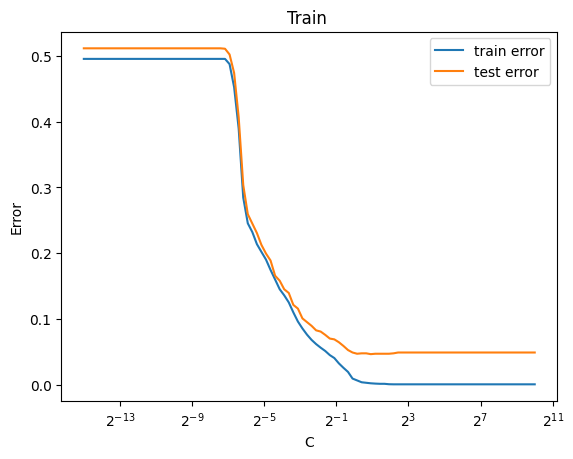

In [21]:
import matplotlib.pyplot as plt
plt.plot( Cs, train_errors, label='train error')
plt.plot( Cs, val_errors, label='test error')

plt.title('Train ')
plt.ylabel('Error')
plt.xlabel('C')
plt.xscale("log",base=2)
plt.legend();

In [27]:
#pick the C the C that has the lowest test error and also it is the lowest C.
val_errors = np.array(val_errors)
best_C = Cs[val_errors.argmin()]
print(f'C:{best_C:.2f},val error:{val_errors.min()}')

C:1.88,val error:0.04625000000000001


In [29]:
clf_cosine= SVC(kernel='precomputed',C=best_C)
X_train_cosine = cosine_similarity(X_train)
clf_cosine.fit(X_train_cosine, y_train)
X_test_cosine  =cosine_similarity(X_test, X_train)
accurarcy_cosine_n_1_3 = clf.score(X_test_cosine, y_test)

Ahora elegimos el kernel chi2

In [8]:
# cambiemos de kernel
# Dividir los datos en entrenamiento y prueba
X_cut = X[0:2000]
etiquetas_cut = etiquetas[0:2000]
# Dividir los datos en entrenamiento y prueba (usamos menos datos porque se demora mucho en correr)
X_train, X_test, y_train, y_test = train_test_split(X_cut, etiquetas_cut, test_size=0.2, random_state=42)
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train_chi2 = chi2_kernel(X_train.toarray())
X_test_chi2 = chi2_kernel(X_test.toarray(), X_train.toarray())
val_errors = [ ]
train_errors = [ ]
Cs = np.logspace(-15, 10, 100,base=2)
X_train_chi_ = chi2_kernel(X_train_.toarray())
X_val_chi  =chi2_kernel(X_val.toarray(), X_train_.toarray())
for C in Cs :
    clf = SVC(kernel='precomputed',C=C)
    clf.fit(X_train_chi_, y_train_)
    train_error = 1 - clf.score(X_train_chi_, y_train_)
    val_error = 1- clf.score(X_val_chi, y_val)
    val_errors.append(val_error)
    train_errors.append(train_error)

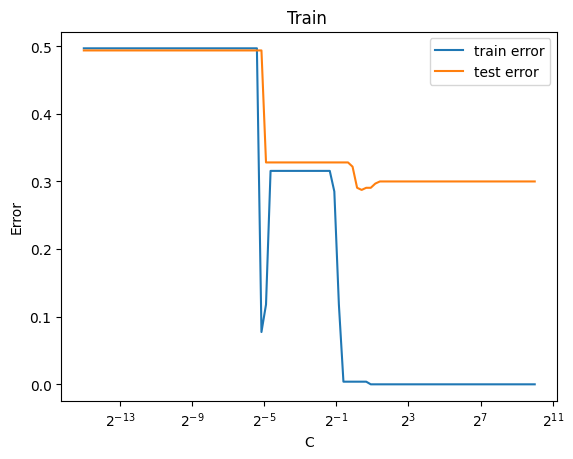

In [19]:
import matplotlib.pyplot as plt
plt.plot( Cs, train_errors, label='train error')
plt.plot( Cs, val_errors, label='test error')

plt.title('Train ')
plt.ylabel('Error')
plt.xlabel('C')
plt.xscale("log",base=2)
plt.legend();

In [15]:
#pick the C the C that has the lowest test error and also it is the lowest C.
val_errors = np.array(val_errors)
best_C = Cs[val_errors.argmin()]
print(f'C:{best_C:.2f},val error:{val_errors.min()}')

C:1.32,val error:0.2875


In [11]:
clf = SVC(kernel='precomputed',C=1.32)
X_train_chi = chi2_kernel(X_train.toarray())
clf.fit(X_train_chi, y_train)
X_test_chi  =chi2_kernel(X_test.toarray(), X_train.toarray())
accurarcy_chi_n_1_3 = clf.score(X_test_chi, y_test)

In [93]:
# Crear vectores de características utilizando CountVectorizer
# ngram_range: cuáles n-gramas considerar
vectorizer = CountVectorizer(ngram_range =(1,4))
X = vectorizer.fit_transform(palabras)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, etiquetas, test_size=0.2, random_state=42)
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

val_errors = [ ]
train_errors = [ ]
Cs = np.logspace(-15, 10, 100,base=2)
X_train_cosine_ = cosine_similarity(X_train_)
X_val_cosine  =cosine_similarity(X_val, X_train_)
for C in Cs :
    clf = SVC(kernel='precomputed',C=C)
    clf.fit(X_train_cosine_, y_train_)
    train_error = 1 - clf.score(X_train_cosine_, y_train_)
    val_error = 1- clf.score(X_val_cosine, y_val)
    val_errors.append(val_error)
    train_errors.append(train_error)

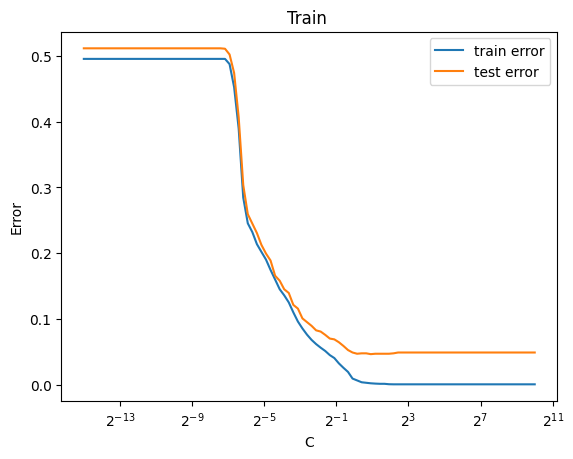

In [23]:
import matplotlib.pyplot as plt
plt.plot( Cs, train_errors, label='train error')
plt.plot( Cs, val_errors, label='test error')

plt.title('Train ')
plt.ylabel('Error')
plt.xlabel('C')
plt.xscale("log",base=2)
plt.legend();

In [24]:
#pick the C the C that has the lowest test error and also it is the lowest C.
val_errors = np.array(val_errors)
best_C = Cs[val_errors.argmin()]
print(f'C:{best_C:.2f},val error:{val_errors.min()}')

C:1.88,val error:0.04625000000000001


In [25]:
clf  = SVC(kernel='precomputed',C=best_C)
X_train_cosine = cosine_similarity(X_train)
clf.fit(X_train_cosine, y_train)
X_test_cosine  =cosine_similarity(X_test, X_train)
accurarcy_cosine_n_1_4 = clf.score(X_test_cosine, y_test)

In [49]:
import pandas as pd
# Compare predicted labels with actual labels
y_pred_cosine = clf.predict(X_test_cosine)
incorrect_items = [vectorizer.inverse_transform(X_test[i])[0].tolist() for i in range(len(y_test)) if y_pred_cosine[i] != y_test[i]]
y_label = [y_test[i] for i in range(len(y_test)) if y_pred_cosine[i] != y_test[i]]
table = pd.DataFrame({'incorrect_items':incorrect_items,'y_label':y_label})



In [53]:
table.head(15)

,incorrect_items,y_label
0,"[bion, tur, tur bion]",español
1,"[ba, ba hamas, hamas]",inglés
2,"[as, as cua, cua]",español
3,"[fe, fe males, males]",inglés
4,"[par, par til, til]",español
5,"[nir, nir vana, vana]",inglés
6,"[ocha, ocha von, von]",español
7,"[cur, cur sion, in, in cur, in cur sion, sion]",español
8,"[beo, plum, plum beo]",español
9,"[car, car roll, roll]",inglés


Se puede observar que por ejemplo en el segundo caso "bahamas" o en la fila 5, "nirvana" se escriben de la misma manera en inglés y en español. 

En la siguiente celda se resumen los mejores resultados de c para 2 kernel distintos y una variacion de n-grama, con su respectivo accuracy. Cosine obtuvo el mejor desempeño, y no cambio mucho al aumentar los n-gramas a 4.

In [26]:
import pandas as pd
tabla = pd.DataFrame([{'kernel': 'Cosine','n-gram': 'n =[1,3]','parameter': 'c=1.32', 'Accuracy': accurarcy_cosine_n_1_3},
                      {'kernel': 'chi2','n-gram': 'n =[1,3]','parameter': 'c=1.32', 'Accuracy': accurarcy_chi_n_1_3},
                      {'kernel': 'Cosine','n-gram': 'n =[1,4]','parameter': 'c=1.88', 'Accuracy': accurarcy_cosine_n_1_4}])
tabla

,kernel,n-gram,parameter,Accuracy
0,Cosine,"n =[1,3]",c=1.32,0.9435
1,chi2,"n =[1,3]",c=1.32,0.7925
2,Cosine,"n =[1,4]",c=1.88,0.9445


# 2.
En la siguiente celda preparamos los datos de MNIST para ser entrenados con SVM. Primero cargamos los datos desde el enlace proporcionado. Después de eso, utilizamos la función StandardScaler(), que según la documentación hace lo siguiente: "Estandariza las características eliminando la media y escalando a varianza unitaria".
Luego seleccionamos dos dígitos de los 9 disponibles. Elegimos 0 y 1.

In [54]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#import dataset
train_samples = 5000
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
#splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000
)
#standardizing the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#pick only two of them 0 and 1 digits
# For train dataset
train_mask = (y_train == '0') | (y_train == '1')
X_train_filtered = X_train[train_mask]
y_train_filtered = y_train[train_mask]

# For test dataset
test_mask = (y_test == '0') | (y_test == '1')
X_test_filtered = X_test[test_mask]
y_test_filtered = y_test[test_mask]

c:\Users\acmor\miniconda3\envs\mlcourse\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


En la siguiente celda utilizamos SVC para entrenar un clasificador variando iterativamente el parámetro C. Mantenemos un registro del error de cada clasificador en una lista.

In [55]:
from sklearn.svm import SVC
import numpy as np
test_errors = [ ]
train_errors = [ ]
Cs = np.logspace(-15, 10, 1000,base=2)
for C in Cs :
    clf = SVC(kernel='linear',C=C)
    clf.fit(X_train_filtered, y_train_filtered)
    train_error = 1 - clf.score(X_train_filtered, y_train_filtered)
    test_error = 1- clf.score(X_test_filtered, y_test_filtered)
    test_errors.append(test_error)
    train_errors.append(train_error)

Graficamos los resultados de Test y Train versus C, y luego seleccionamos el C con el menor error en el conjunto de prueba.

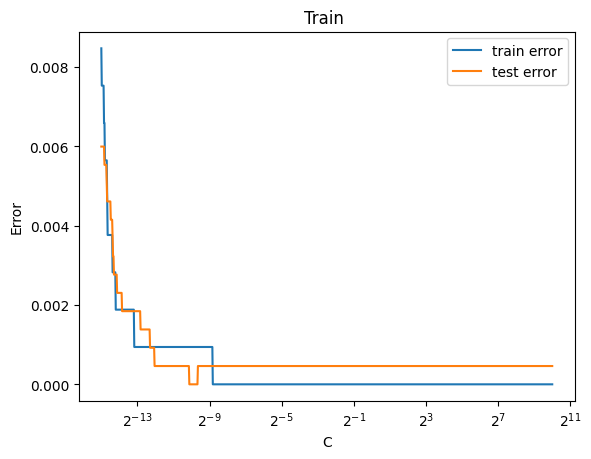

In [56]:
import matplotlib.pyplot as plt
plt.plot( Cs, train_errors, label='train error')
plt.plot( Cs, test_errors, label='test error')

plt.title('Train ')
plt.ylabel('Error')
plt.xlabel('C')
plt.xscale("log",base=2)
plt.legend();


In [57]:
#pick the C the C that has the lowest test error and also it is the lowest C.
test_errors = np.array(test_errors)
best_C = Cs[test_errors.argmin()]

Weights shape: (1, 784)


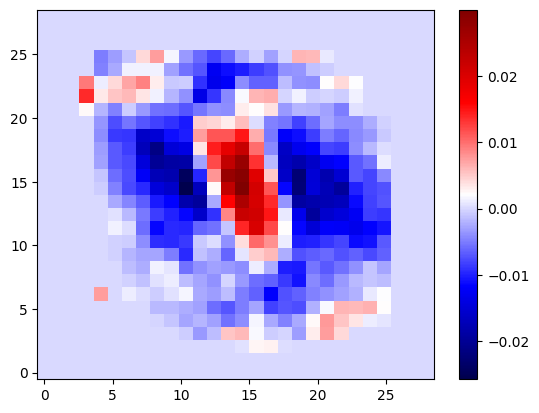

In [58]:
#chosen model 
clf = SVC(kernel='linear',C=best_C)
clf = clf.fit(X_train_filtered, y_train_filtered)
weights = clf.coef_
print('Weights shape:', weights.shape)
#rearrange shape to 28x28
weights = weights.reshape(28, 28)
#colormap
plt.pcolor(np.linspace(0,28,28),np.linspace(0,28,28),weights, cmap='seismic', vmin=weights.min(), vmax=weights.max());
plt.colorbar();

Análisis:
La barra de colores muestra que los valores extremadamente negativos son azul oscuro, mientras que los valores extremadamente positivos son rojos. En la imagen, el centro tiene los valores positivos más altos rodeados por una nube de pesos negativos, mientras que el fondo (donde usualmente no hay contenido de píxeles o información) tiene pesos de 0.

El SVM lineal clasifica las imágenes multiplicando estos pesos por la imagen, como un producto escalar, y luego añadiendo el sesgo. Los valores que son menores a -1 se clasifican como '0' y los valores que son mayores a 1 se clasifican como '1'. En la siguiente celda de código, podemos observar con la misma barra de colores algunas de las imágenes de prueba, podemos ver que el dígito '1' usualmente tiene valores extremadamente positivos en el centro, por lo tanto, tiene sentido tener pesos positivos, para obtener valores mayores que 1. Por el contrario, los píxeles de '0' generalmente tienen valores altos positivos alrededor del centro, y el centro está vacío, entonces tiene sentido establecer pesos negativos para que el producto escalar resulte en un valor negativo.

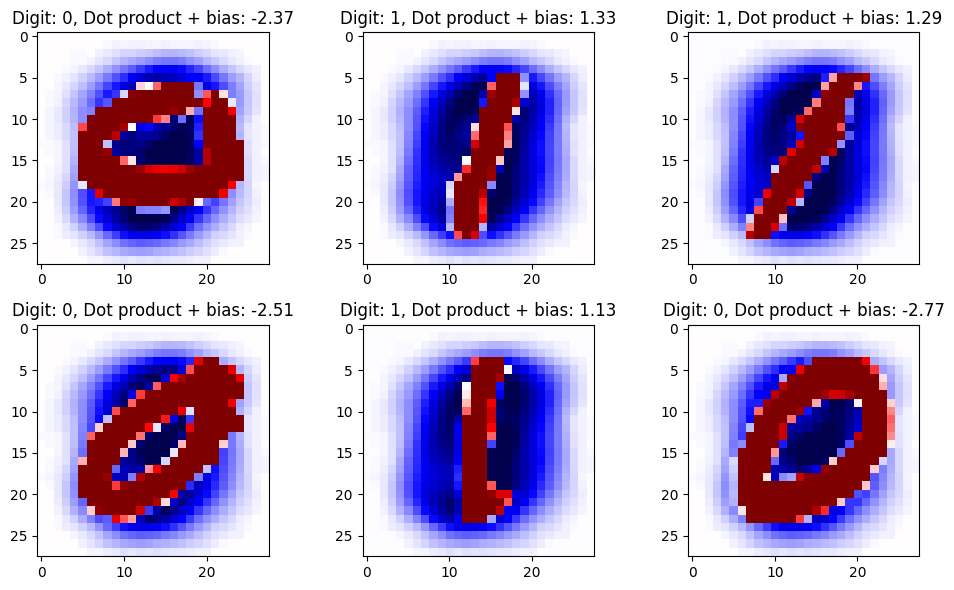

In [59]:

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# Reshape the X_test_filtered array to have shape (num_samples, 28, 28)
X_test_reshaped = X_test_filtered.reshape(-1, 28, 28)

# Iterate over the first 6 samples
for i in range(6):
    # Plot the digit image
    axes[i//3, i%3].imshow(X_test_reshaped[i], cmap='seismic', vmin=-1, vmax=1)
    # Set the title as the corresponding digit label
    dot_product = np.dot(X_test_filtered[i], weights.flatten())+clf.intercept_
    axes[i//3, i%3].set_title(f"Digit: {y_test_filtered[i]}, Dot product + bias: {dot_product[0]:.2f}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

En la siguiente celda vamos a examinar dos dígitos que suelen ser similares, el 3 y el 8. Podemos observar que para el valor más pequeño de C, el error es el mayor; las zonas más azules oscuras tienen la forma de un 3, mientras que los valores rojos más oscuros toman la forma de un 8. Aumentar C reduce el error hasta cierto punto, pero eventualmente no cambia mucho y los pesos comienzan a aparecer de manera aleatoria y concentrados en el centro, sin embargo, la principal concentración de zonas azules que se asemejan a un 3 permanece ligeramente.

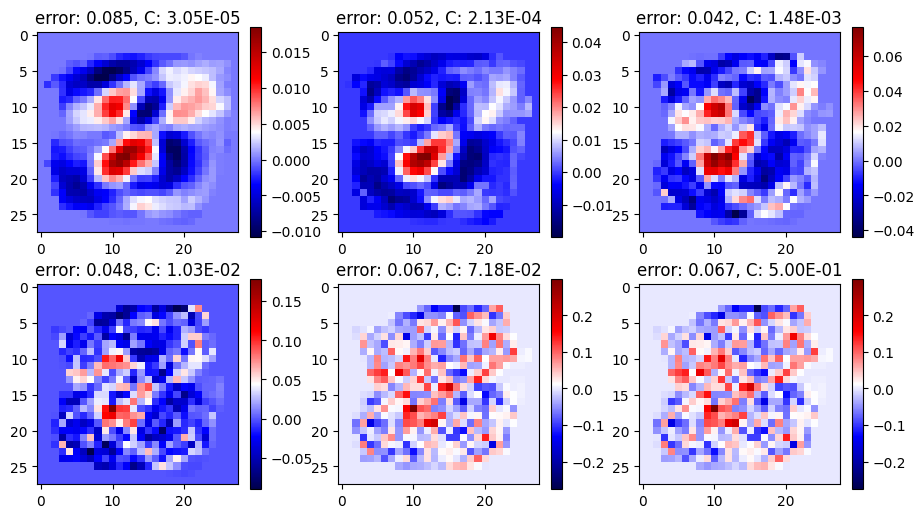

In [60]:
import numpy as np
# For train dataset
train_mask = (y_train == '3') | (y_train == '8')
X_train_filtered = X_train[train_mask]
y_train_filtered = y_train[train_mask]

# For test dataset
test_mask = (y_test == '3') | (y_test == '8')
X_test_filtered = X_test[test_mask]
y_test_filtered = y_test[test_mask]

fig, axes = plt.subplots(2, 3, figsize=(11, 6))
Cs = np.logspace(-15, -1, 6,base=2)
for i in range(6):
    #chosen model       
    c = Cs[i]
    clf = SVC(kernel='linear',C=c)
    clf = clf.fit(X_train_filtered, y_train_filtered)
    weights = clf.coef_
    #rearrange shape to 28x28
    weights = weights.reshape(28, 28)
    #colormap
    plt.colorbar(axes[i//3, i%3].imshow(weights, cmap='seismic', vmin=weights.min(), vmax=weights.max()))
    test_error = 1- clf.score(X_test_filtered, y_test_filtered)
    axes[i//3, i%3].set_title(f"error: {test_error:.3f}, C: {c:.2E}")

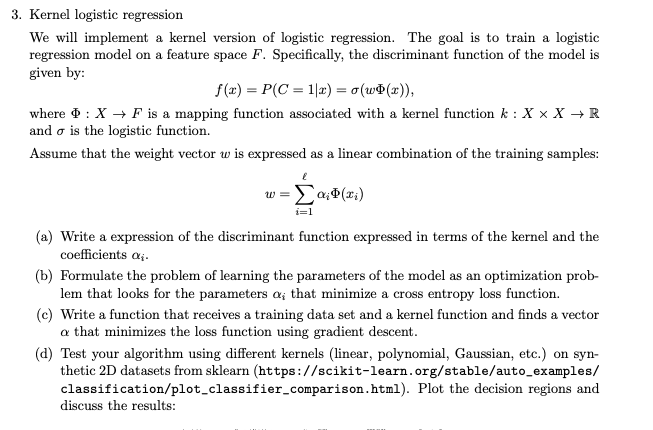

# 3). (a) Notemos que $\vec{w}\cdot\vec{\Phi}(x) = (\sum_i \alpha_i \vec{\Phi}(x_i))\cdot\vec{\Phi}(x) = \sum_i \alpha_i (\vec{\Phi}(x_i)\cdot\vec{\Phi}(x)) = \sum_i \alpha_i k(x_i,x) .$ #
# Luego $f(x|\vec{\alpha}) = \sigma(\sum_i \alpha_i k(x_i,x))$. #

# (b) La pérdida de un solo ejemplo $(x,y)$, donde $x$ son las características y $y$ es la etiqueta, es $l(x,y|\vec{\alpha}) = -y\log(f(x)) -(1-y)\log(1-f(x))$. Para un conjunto de entrenamiento $\{(x_j,y_j)\}_j$ buscamos minimizar $L(\vec{\alpha}) = \sum_j l(x_j,y_j|\vec{\alpha}). $ #

# (c) La función que regresa el $\alpha$ es 'optimizar' #

In [9]:
import sklearn as sk
import numpy as np
def sigma(x):
    return 1/(1+np.exp(-x))
#predecir P(C=1|x), la posterior
def pred_proba(x,alfa,kernel,datosX):
    s = 0
    for i in range(len(alfa)):
        s += alfa[i]*kernel(datosX[i],x)
    return sigma(s) 
#gradiente
def grad(datosX,datosY, kernel, alfa):
    n_ejs = len(datosY)
    #predecir posterior para todos los datos
    f = []
    for _, x in enumerate(datosX):
        f.append(pred_proba(x,alfa,kernel,datosX))
    f = np.array(f)
    #calcular derivadas de la pérdida respecto a f(x_j)
    dL_df = []
    for j in range(n_ejs):
        dL_df.append((f[j]-datosY[j])/(f[j]*(1-f[j])))
    #calcular derivadas de f(x_j) respecto a alfa_i
    df_dalfa = np.zeros((n_ejs,n_ejs))
    for i in range(n_ejs):
        for j in range(n_ejs):
            df_dalfa[i][j] = f[j]*(1-f[j])*kernel(datosX[i],datosX[j]) 
    df_dalfa = np.array(df_dalfa)
    #calcular gradiente
    grad = df_dalfa@dL_df
    return grad
def perdida(datosX,datosY,kernel,alfa):
    n_ejs = len(datosY)
    per = []
    for j in range(n_ejs):
        y_p = pred_proba(datosX[j],alfa,kernel,datosX)
        per.append(-np.log(y_p**datosY[j]*(1-y_p)**(1-datosY[j])))
    per = np.array(per)
    return per.sum()
def optimizar(datosX,datosY, kernel, iter, lr, alfa):
    #inicializar alfa
    n_ejs = len(datosY)
    #descenso del grandiente
    for i in range(iter):
        if i%100 == 0:
            print('Ciclo ',i,' Pérdida:', perdida(datosX,datosY,kernel,alfa))
        alfa -= lr*grad(datosX,datosY, kernel, alfa)
    return alfa
#predecir punto a punto         
def pred(X,alfa,kernel,datosX):
    return np.round(pred_proba(X,alfa,kernel,datosX))
    

# (d) Cargar datos #

In [10]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
X, y = make_blobs(n_samples=100, centers=[[0.36 , 1.36 ],
       [1.13, 2.03],
       [0.29, 2.48]], cluster_std=0.35, n_features=2, random_state=17)
y = np.array([0 if label == 0 else 1 for label in y])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)


# Definir diferentes kernel #

In [11]:
import math as m
kernels = []
def kernel_lineal(a,b):
    return np.dot(a,b)+3
kernels.append(kernel_lineal)
def kernel_polinomial(a,b):
    return (np.dot(a,b)-2.5)**3
kernels.append(kernel_polinomial)
def kernel_gaussiano(a,b):
    return np.exp(-m.dist(a,b)**2)
kernels.append(kernel_gaussiano)
    

# Probar esquema con kernel lineal $k(\vec{a},\vec{b}) = \vec{a} \cdot \vec{b} + 3$ #

In [12]:
n_ejs = len(y_train)
a = optimizar(X_train,y_train,kernels[0],300,.00001,-0.8*np.ones(n_ejs))
def g(X):
    return pred(X,a, kernels[0], X_train)
#predecir en datos de prueba
predicciones = [g(X_test[i]) for i in range(len(X_test))]
#precisión
def prec(predicciones,y):
    aciertos = 0
    for i, c in enumerate(y):
        if predicciones[i] == c:
            aciertos += 1
    return aciertos/len(y)


Ciclo  0  Pérdida: 26507.86668186711
Ciclo  100  Pérdida: 12325.919196563416
Ciclo  200  Pérdida: 19.819896139904728


In [13]:
print('Aciertos en datos de prueba:',100*prec(predicciones,y_test),'%')

Aciertos en datos de prueba: 85.0 %


# Visualizar regiones y datos #

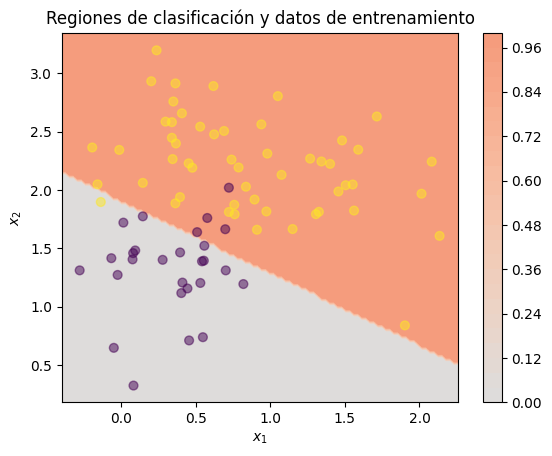

In [14]:
def plot_decision_region(X, pred_fun):
    """
    X: corresponde a las instancias de nuestro conjunto de datos
    pred_fun: es una función que para cada valor de X, me regresa una predicción
    """
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    plt.contourf(XX, YY, ZZ, 30, cmap = plt.cm.coolwarm, vmin= -2, vmax=2)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")

plot_decision_region(X_train, lambda x_1, x_2: g([x_1, x_2]))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', alpha=0.5,s=40)
plt.title('Regiones de clasificación y datos de entrenamiento')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()



# Kernel polynomial $k(\vec{a},\vec{b}) = (\vec{a} \cdot \vec{b} -2.5)^2$ #

In [15]:
#parámetros iniciales
a1_ini = np.array([ 3.20944132e-03, -1.33490422e-02,  5.85373298e-03,  7.80762530e-03,
        2.88829152e-03,  6.25652406e-03,  2.94394645e-03,  5.07119363e-03,
        2.87400178e-03, -3.13762964e-03,  2.50896614e-03,  7.86301167e-03,
        2.35341454e-03,  1.46070574e-02,  8.65423121e-03,  2.75423060e-03,
       -8.22349259e-03, -1.37041734e-02,  8.50192047e-03,  2.88764133e-03,
       -1.37094524e-02,  3.03787778e-03,  3.19293939e-03,  2.85358182e-03,
        4.32007529e-03,  3.08452494e-03,  7.90526999e-03,  2.84533086e-03,
        4.30861786e-03,  6.96888931e-03,  6.15727890e-03,  9.54169157e-03,
        7.60114256e-03,  6.01531130e-03,  3.01123672e-03,  6.61621605e-03,
       -1.53318617e-03,  5.35613221e-03,  3.82665413e-03,  1.28415257e-02,
        7.88955654e-03,  2.92173175e-03,  6.77676567e-03,  6.52402676e-03,
        6.16148741e-03,  5.39261910e-03,  1.56038367e-02,  6.69972134e-03,
        3.45178013e-03,  3.00215535e-03,  3.24427561e-02,  6.31625159e-03,
       -2.24002950e-04,  2.54454717e-03,  6.56880718e-03,  2.71061965e-03,
        3.68945512e-03,  5.83725799e-03,  9.15328477e-03,  6.06930480e-03,
        5.78107735e-03,  9.97106679e-03,  7.81694993e-03,  3.66513957e-03,
        4.49312656e-03,  8.80331598e-05,  7.68143773e-03,  3.32137598e-03,
        6.12413657e-03,  6.79257293e-03,  9.21075259e-03,  5.43845480e-03,
       -2.33218998e-03,  3.33410255e-03,  5.65708732e-03,  1.13249080e-02,
        5.92222733e-03,  2.64231183e-03,  5.76382586e-03,  4.79044431e-03])
a1 = optimizar(X_train,y_train,kernels[1],400,.000001,a1_ini)
def g1(X):
    return pred(X,a1, kernels[1], X_train)
#predecir en datos de prueba
predicciones = [g1(X_test[i]) for i in range(len(X_test))]
print('Aciertos en datos de prueba:',100*prec(predicciones,y_test),'%')

Ciclo  0  Pérdida: 26.657277981076696
Ciclo  100  Pérdida: 19.759842172735787
Ciclo  200  Pérdida: 19.065697335723684
Ciclo  300  Pérdida: 18.463102611325986
Aciertos en datos de prueba: 90.0 %


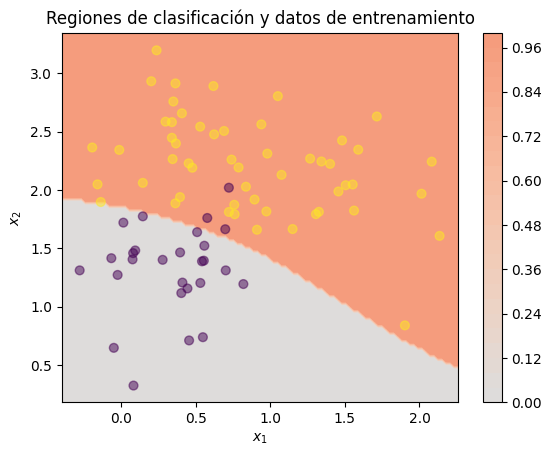

In [16]:
plot_decision_region(X_train, lambda x_1, x_2: g1([x_1, x_2]))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', alpha=0.5,s=40)
plt.title('Regiones de clasificación y datos de entrenamiento')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()


# Kernel gaussiano $k(\vec{a},\vec{b}) = e^{-|\vec{a}-\vec{b}|^2} $ #

In [17]:
a2 = optimizar(X_train,y_train,kernels[2],300,.0005,-0.0005*np.ones(n_ejs))
def g2(X):
    return pred(X,a2, kernels[2], X_train)
#predecir en datos de prueba
predicciones = [g2(X_test[i]) for i in range(len(X_test))]
print('Aciertos en datos de prueba:',100*prec(predicciones,y_test),'%')

Ciclo  0  Pérdida: 55.682652145894934
Ciclo  100  Pérdida: 17.114558484583362
Ciclo  200  Pérdida: 13.498817320468241
Aciertos en datos de prueba: 90.0 %


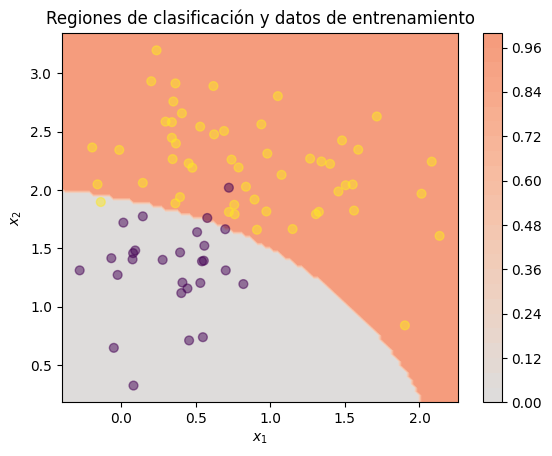

In [18]:
plot_decision_region(X_train, lambda x_1, x_2: g2([x_1, x_2]))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', alpha=0.5,s=40)
plt.title('Regiones de clasificación y datos de entrenamiento')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()
